In [1]:
%matplotlib inline
import numpy as np
import scipy.signal
import cvxpy as cp
import matplotlib.pyplot as plt
import sklearn.mixture as mix

noise std: 17.293730549031064
sqrt(dc) 17.320508075688775


<BarContainer object of 1024 artists>

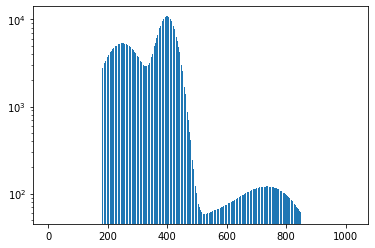

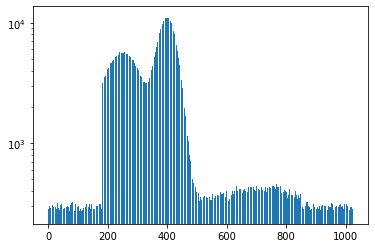

In [124]:
N = 1024
resolution = 640*480
sig_per_pixel = 5
SBR = 5.
noise_per_pixel = sig_per_pixel/SBR
signal_photons = sig_per_pixel*resolution
noise_photons = noise_per_pixel*resolution
def gaussian(mu, sigma):
    return np.exp([-(i - mu)**2/(2*sigma**2) for i in range(N)])
signal = gaussian(250, 60) + 2*gaussian(400, 30) + 0.01*gaussian(550, 120) + 0.02*gaussian(750, 90)
window = [180, 850]
signal[:window[0]] = 0
signal[window[1]:] = 0
signal *= signal_photons/np.sum(signal)
plt.figure()
plt.bar(range(N), signal, log=True)
noisy_signal = signal + noise_photons/N * np.ones(N)
h = np.random.poisson(noisy_signal)
h_dc = np.random.poisson(noise_photons/N*np.ones(N))
print("noise std:", np.std(h_dc))
print("sqrt(dc)", np.sqrt(noise_photons/N))
plt.figure()
plt.bar(range(N), h, log=True)

1799.44921875
299.3
true dc: 300.0


<BarContainer object of 1023 artists>

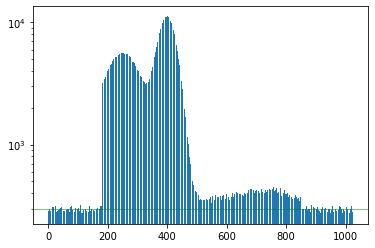

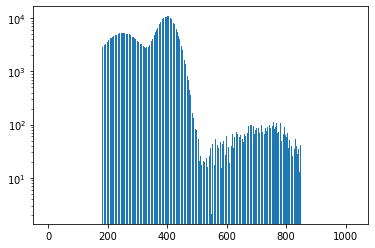

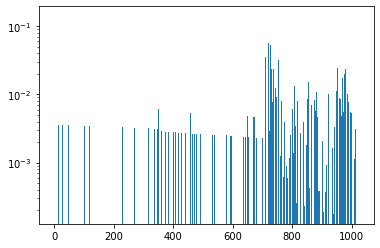

In [125]:
# Use first 100 measurements to estimate ambient level
def anscombe(x):
    return 2*np.sqrt(x + 3./8)
def inv_anscombe(x):
    return (x/2)**2 - 3./8
h_ans = anscombe(h)
# Apply median filter to remove Gaussian Noise
h_ans_filt = scipy.signal.medfilt(h_ans, kernel_size=3)
# Apply Inverse Anscombe Transform
h_eq = inv_anscombe(h_ans_filt)
dc_est_ans = np.mean(h_eq)
print(dc_est_ans)
dc_est = np.mean(h[:100])
print(dc_est)
print("true dc:", noise_photons/N)
threshold = 1.1*dc_est
# plt.bar(range(len(h)), h, log=True)
plt.bar(range(len(h_eq)), h_eq, log=True)
# plt.axhline(y=dc_est, color='r', linewidth=0.5)
# for c in np.linspace(1, 3, 10):
#     plt.axhline(y=c*dc_est, color='g', linewidth=0.5)
plt.axhline(y=dc_est, color='g', linewidth=0.5)
threshold = dc_est + 2*np.sqrt(dc_est)
plt.figure()
plt.bar(range(len(h_eq)), np.clip(h_eq - threshold, a_min=0., a_max=None), log=True)
plt.figure()
plt.bar(range(len(h_eq)-1), np.diff(np.sort(np.log(h_eq) - np.log(dc_est))), log=True)

61.21844660194175


<BarContainer object of 1024 artists>

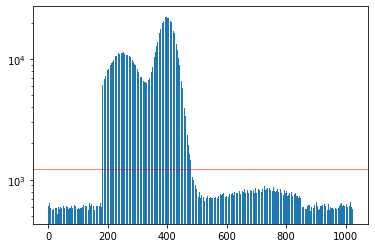

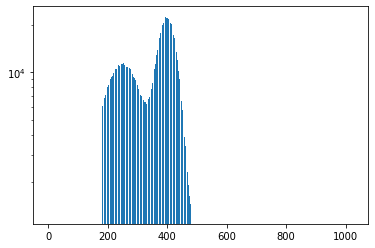

In [111]:
import sklearn.cluster as skcl

h_denoised = h.copy()
model = skcl.DBSCAN(eps=140.)
classes = model.fit_predict(h_nz.reshape(-1,1))
noise_class = min((np.mean(h_nz[classes == i]), i) for i in np.unique(classes))[1]
cutoff = (np.max(h_nz[classes == noise_class]) + np.min(h_nz[classes != noise_class]))/2
plt.bar(range(len(h)), h, log=True)
plt.axhline(y=cutoff, color='r', linewidth=0.5)
h_denoised[h_denoised <= cutoff] = 0.
print(np.mean(h_nz[classes == noise_class]))
plt.figure()
plt.bar(range(len(h_denoised)), h_denoised, log=True)

2


<BarContainer object of 895 artists>

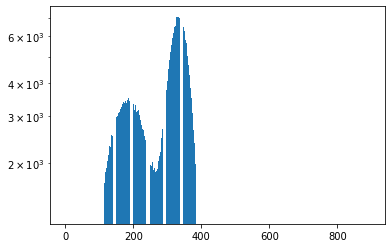

In [67]:
import sklearn.mixture as skmix
# model = skmix.GaussianMixture(n_components=2, means_init=np.array([[0.], [np.mean(h)]]))
model = skmix.GaussianMixture(n_components=2)
h_nz = h[h > 0]
classes = model.fit_predict(np.log(h_nz).reshape(-1, 1))
print(len(np.unique(classes)))
noise_class = np.argmin([np.mean(h_nz[classes == i]) for i in range(2)])
h_noise = h_nz.copy()
h_noise[classes != noise_class] = 0.
h_signal = h_nz.copy()
h_signal[classes == noise_class] = 0.

# plt.bar(range(len(h_nz)), h_noise, log=True)
plt.bar(range(len(h_nz)), h_signal, log=True)


<BarContainer object of 1024 artists>

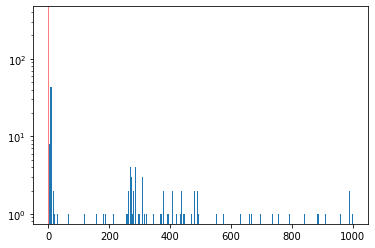

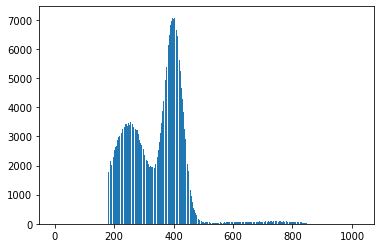

In [50]:
# Given ambient level, find all measurements within range:
h_find_dc, bins = np.histogram(h, bins=1000)
# print(bins)
# for i, val in enumerate(bins[1:]):
#     if val >= dc_est/3:
#         cutoff = bins[i-1]
#         break
plt.bar(range(len(h_find_dc)), h_find_dc, log=True)
plt.axvline(x=cutoff, color='r', linewidth=0.5)
h_denoised = h.copy()
h_denoised[h_denoised - dc_est <= cutoff] = 0
plt.figure()
plt.bar(range(len(h_denoised)), h_denoised)

In [ ]:
# Optimize but use regularization on ambient level z


1


<BarContainer object of 68 artists>

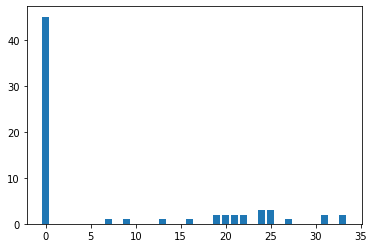

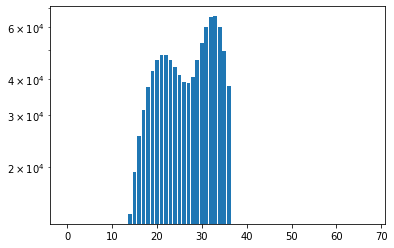

In [226]:
import sklearn.mixture as skmix
def remove_dc_from_spad_gmm(h):
    assert len(h.shape) == 1
    h_hist_hist, cutoffs = np.histogram(h, bins=len(h)//2)
#     plt.bar(range(N//2), h_hist_hist)
    model = skmix.GaussianMixture(n_components=2)
    classes = model.fit_predict(h_hist_hist.reshape(-1,1))
    i = np.argmax(np.abs(np.diff(classes)))
#     print(i+1)
#     np.sum(h <= cutoffs[i+1])
    dc = np.mean(h[h <= cutoffs[i+1]])
    h[h <= cutoffs[i+1]] = 0.
    h = h.astype('float') - dc
#     plt.figure()
#     plt.bar(range(len(h)), h, log=True)
    return h

In [191]:
# plt.bar(range(N), signal, log=True)
# plt.figure()
# plt.bar(range(N), h, log=True)
# plt.title("h")
# plt.ylim(1e0, 1e5)
# plt.figure()
# plt.bar(range(N), h - np.min(h), log=True)
def anscombe(x):
    return 2*np.sqrt(x + 3./8)
def inv_anscombe(x):
    return (x/2)**2 - 3./8
h_ans = anscombe(h)
# Apply median filter to remove Gaussian Noise
h_ans_filt = scipy.signal.medfilt(h_ans, kernel_size=7)
# Apply Inverse Anscombe Transform
h_eq = inv_anscombe(h_ans_filt)
# plt.figure()
# plt.bar(range(N), h_eq - np.min(h_eq), log=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.972e+01  +3e+02  8e-01  1e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -1.541e+02  -1.714e+02  +8e+01  6e-01  1e+00  3e+00  3e-01  0.7131  5e-03   1  1  1 |  0  1
 2  -9.279e+02  -9.335e+02  +2e+01  6e-01  1e+00  2e+01  7e-02  0.7833  2e-02   1  1  1 |  1  1
 3  -2.065e+03  -2.055e+03  +9e+00  6e-01  1e+00  3e+01  3e-02  0.6266  2e-01   1  1  1 |  3  2
 4  -3.651e+03  -3.623e+03  +5e+00  6e-01  1e+00  5e+01  2e-02  0.9791  6e-01   1  1  1 |  8  0
 5  -9.329e+03  -9.231e+03  +2e+00  6e-01  1e+00  1e+02  8e-03  0.6266  7e-02   1  1  1 |  2  2
 6  -1.856e+04  -1.837e+04  +1e+00  6e-01  1e+00  2e+02  4e-03  0.9791  5e-01   1  1  1 |  7  0
 7  -4.126e+04  -4.082e+04  +5e-01  6e-01  1e+00  5e+02  2e-03  0.6266  1e-01   1  1  1 |  3  2
 8  -8.025e+04  -7.943e+04  +3e-01  7e-01  1e+

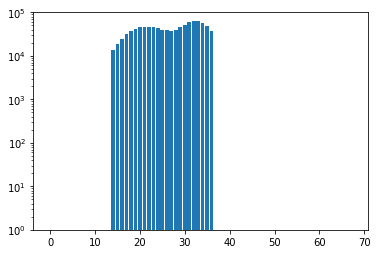

In [196]:
x = cp.Variable((N,), "signal")
b = cp.Variable((1,), "dc")
lam = 1e-1
# lam2 = 1e-1
obj = -noisy_signal*cp.log(b + x) + cp.sum(b + x) + lam*cp.norm(x, 2) # + lam2*cp.norm(cp.diff(x), 1)
constr = [b >= 0, x >= 0]
prob = cp.Problem(cp.Minimize(obj), constr)
prob.solve(verbose=True)
plt.bar(range(N), x.value, log=True)
plt.ylim(1e0, 1e5)
# plt.plot(range(N), np.mean(x.value)*np.ones(N))
print("b", b.value)
print("true b", dc_photons/N)
print("x error", np.sqrt(np.mean((x.value*np.sum(signal)/np.sum(x.value) - signal)**2)))

In [152]:
np.sum(x.value)

989992.1874772719

In [153]:
np.sum(signal)

1000000.0